# TensorLy
decomposition, tensor learning, tensor algebra 등을 수행해주는 파이썬 라이브러리이다.<br>
Numpy, PyTorch, JAX, MXNet, TensorFlow, Cupy 등의 라이브러리 들과 호환화여 활용 가능하다.

In [6]:
import tensorly as tl
import numpy as np

# 텐서 표현

In [14]:
X = tl.tensor(np.arange(24).reshape((3,4,2)), dtype=tl.float32)
X

array([[[ 0.,  1.],
        [ 2.,  3.],
        [ 4.,  5.],
        [ 6.,  7.]],

       [[ 8.,  9.],
        [10., 11.],
        [12., 13.],
        [14., 15.]],

       [[16., 17.],
        [18., 19.],
        [20., 21.],
        [22., 23.]]], dtype=float32)

In [10]:
X[:, :, 0]

array([[ 0.,  2.,  4.,  6.],
       [ 8., 10., 12., 14.],
       [16., 18., 20., 22.]], dtype=float32)

위와 같이 TensorLy는 넘파이 배열을 입력으로 받아 텐서를 표현할 수 있다.<br>
또한 Slicing을 이용할 수 있다.

# 텐서 언폴딩

예전에 `torch.nn.Unfold`와 비슷하지만 다르다. <br>
텐서를 쪼갠다, 분리한다라는 개념은 동일하지만 `mode`라는 개념이 강하게 작용한다.

### 모드란?<br>
모드는 텐서의 차원 중 하나를 나타낸다. (dim, axis와 같은 의미로 사용된다.)<br>
unfold의 n-mode 연산은 n-dim 혹은 axis=n을 기준으로 텐서를 펼친다는 의미이다.<br>

예시) <br>
(3,4,5)의 텐서를 모드 0으로 unfold 하는 경우 <br>
이는 텐서를 dim = 0을 기준으로 펼치는 것을 의미한다. dim = 0은 depth-wise이다.<br>
펼친다는 개념이 모호할 수 있다. 인덱스 슬라이싱으로 나타내면 [0, :, :], [1, :, :], [2, :, :] 이렇게 끊어서 본다는 의미이다.<br>
이후 이 텐서는 (3,4*5) 크기가 된다. 이는 각 채널의 행렬이 새로 언폴드된 행렬의 각 row로 들어감을 의미한다.<br>
<font color='yellow'> n-mode로 Unfold시 반환되는 텐서는 2차원 행렬이 된다. 따라서 특정 축을 기준으로 슬라이싱 된 행렬은 반환되는 텐서의 각 행에 들어간다. </font>


### 부가적인 특징<br>
- 0-index로 mode 표현<br>
- C-ordering + Alpha로 수행되어 빠름



In [27]:
X

array([[[ 0.,  1.],
        [ 2.,  3.],
        [ 4.,  5.],
        [ 6.,  7.]],

       [[ 8.,  9.],
        [10., 11.],
        [12., 13.],
        [14., 15.]],

       [[16., 17.],
        [18., 19.],
        [20., 21.],
        [22., 23.]]], dtype=float32)

In [28]:
# depthwise, channel wise로 펼쳐진다.
tl.unfold(X, mode=0)

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11., 12., 13., 14., 15.],
       [16., 17., 18., 19., 20., 21., 22., 23.]], dtype=float32)

In [16]:
# row wise로 텐서를 펼친다.
tl.unfold(X, mode=1)

array([[ 0.,  1.,  8.,  9., 16., 17.],
       [ 2.,  3., 10., 11., 18., 19.],
       [ 4.,  5., 12., 13., 20., 21.],
       [ 6.,  7., 14., 15., 22., 23.]], dtype=float32)

In [17]:
tl.unfold(X, mode=2)

array([[ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22.],
       [ 1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23.]],
      dtype=float32)

# N-mode 연산
위에서 본 언폴딩을 통해서 N 모드에 대응되는 Slice로 언폴딩을 한 후 축을 맞춘 다음에 행렬 곱셈처럼 연산이 가능해진다.

이를 직관적으로 이해하는 것은 다음과 같다. <br>
기존의 텐서 X는 (3,4,2)의 텐서이다. <br>
새로 정의하는 텐서 M은 (5,4)의 텐서이다. <br>
이때 텐서 X와 M의 n-mode 연산은 n 차원을 대상으로 행렬곱이 수행된다.<br>
예를 들어 n이 1인 경우 (이때 n은 0-index) X의 1-dim을 대상으로 행렬곱이 수행됨으로 4 -> 5가 되어 연산후의 크기는 (3,5,2)가 된다. <br>
더 직관적으로 이해하려면 n번째 차원에 곱하려는 행렬이 붙어서 곱해진다고 생각하면 된다.

In [31]:
M = tl.tensor(np.arange(4*5).reshape((5,4)))
print(M.shape)

(5, 4)


In [33]:
res = tl.tenalg.mode_dot(X, M, mode=1)
res.shape

(3, 5, 2)

이때 다음과 같이 n-mode 연산 수행시 n번쨰 차원의 크기가 맞지 않을 경우 에러가 발생한다.

In [35]:
M = tl.tensor(np.arange(4*5).reshape((4,5)))
res = tl.tenalg.mode_dot(X, M, mode=1)

ValueError: shapes (3, 4, 2) and (4, 5) not aligned in mode-1 multiplication: 4 (mode 1) != 5 (dim 1 of matrix)

# 샘플 이미지
TensorLy의 CP decomposition과 Tucker decomposition 적용해보기 전에 먼저 실험해볼 샘플이미지를 하나 불러오겠다.

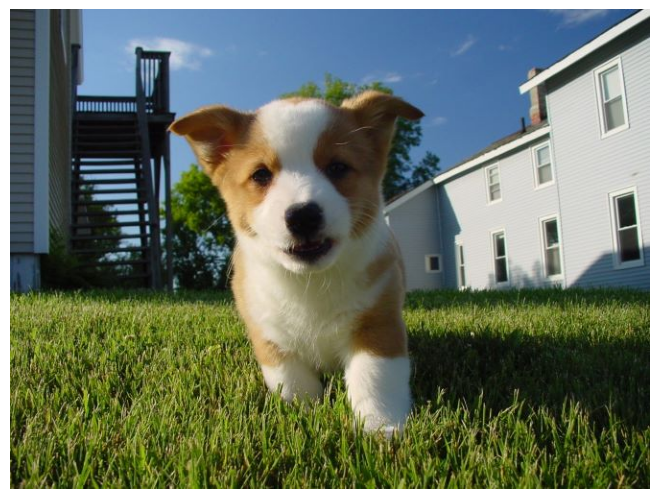

In [112]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

image_path = "./sample_image.png"
image = Image.open(image_path)

# 샘플 이미지
plt.imshow(image)
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor()           
])
image_tensor = transform(image)

tl_tensor = tl.tensor(image_tensor)

# CP decomposition

CP decomposition은 TensorLy의 parafac 함수를 사용해서 적용할 수 있다.

인자로는 tensor와 rank를 입력받고 CPTensor(weight $\lambda$, factors)를 리턴한다.

In [98]:
from tensorly.decomposition import parafac

weights, factors = parafac(tensor=tl_tensor, rank=5)
cp_reconstruction = tl.cp_to_tensor((weights, factors))
cp_img = np.clip(cp_reconstruction.transpose(1, 2, 0),0,1)

# Tucker decomposition

Tucker decomposition은 TensorLy의 tucker 함수를 사용해서 적용할 수 있다.

인자로는 tensor와 rank를 입력받고 (core, factors)를 리턴한다.

In [99]:
from tensorly.decomposition import tucker

core, factors = tucker(tensor=tl_tensor, rank=5)
tk_reconstruction = tl.tucker_to_tensor((core, factors))
tk_img = np.clip(tk_reconstruction.transpose(1, 2, 0),0,1)

/home/csh/.cache/pypoetry/virtualenvs/dlpoetry-5eG4FEyD-py3.10/lib/python3.10/site-packages/tensorly/tucker_tensor.py:425: RuntimeWarning: Given only one int for 'rank' for decomposition a tensor of order 3. Using this rank for all modes.
  warnings.warn(message, RuntimeWarning)


최종적으로 나온 결과를 비교해보면 다음과 같다.

Text(0.5, 1.0, 'TK-Decomp: Rank 5')

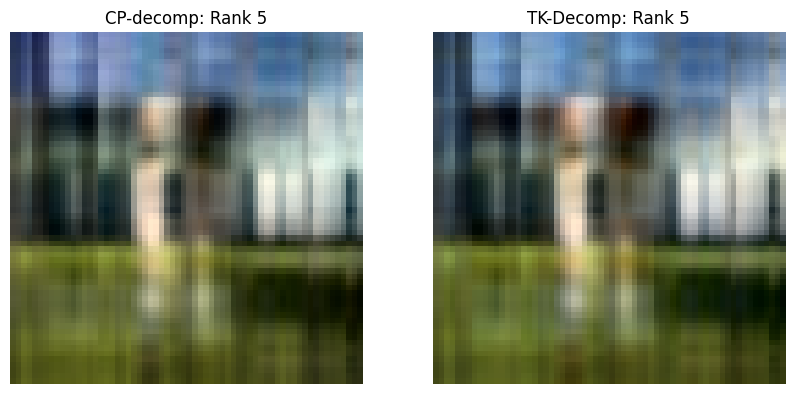

In [102]:
fig, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(cp_img)
axes[0].axis("off")
axes[0].set_title("CP-decomp: Rank 5")
axes[1].imshow(tk_img)
axes[1].axis("off")
axes[1].set_title("TK-Decomp: Rank 5")

# Convolution Filter 압축하기

지금까지 이미지를 대상으로 수행했다면 이제는 Conv filter를 대상으로 수행하겠다. <br>
먼저 샘플이미지를 grayscale로 변환하겠다.

torch.Size([1, 224, 224])


(-0.5, 223.5, 223.5, -0.5)

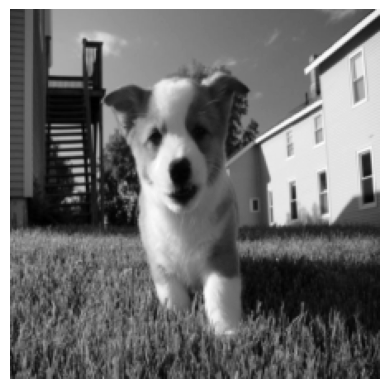

In [146]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()           
])
gray_img = transform(image)
print(gray_img.shape)
plt.imshow(gray_img.squeeze(0), cmap='gray')
plt.axis("off")

Convolution Filter 정의
- blur
- sharpen
- outline
- emboss

In [174]:
# Define conv weights
weight_tensor = np.zeros((4, 3, 3))

# ch 0: blur
weight_tensor[0] = np.array(
    [[0.0625, 0.125, 0.0625], [0.125, 0.25, 0.125], [0.0625, 0.125, 0.0625]]
)

# ch 1: sharpen
weight_tensor[1] = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

# ch 2: outline
weight_tensor[2] = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])

# ch 3: emboss
weight_tensor[3] = np.array([[-2, -1, 0], [-1, 1, 1], [0, 1, 2]])
weight_tensor = np.expand_dims(weight_tensor, 1)

transform_type = ['blur', 'sharpen', 'outline', 'emboss']

# 각각을 CP와 Tucker Decomposition을 수행하는 코드 - Rank는 weight_tensor의 full rank로
weights, factors = parafac(tensor=weight_tensor, rank=4)
cp_reconstruction = tl.cp_to_tensor((weights, factors))

core, factors = tucker(tensor=weight_tensor, rank=4)
tk_reconstruction = tl.tucker_to_tensor((core, factors))

numpy로 정의된 커널들을 torch.nn의 Conv2d 커널로 바꾸는 함수 정의

In [175]:
import torch
import torch.nn as nn

def weight_to_conv(weight):
    weight = torch.tensor(weight, dtype=torch.float32)
    _,h,w = weight.shape
    conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(h,w), padding=1, bias=False)
    conv.weight.data = weight.expand(1,1,3,3)
    return conv

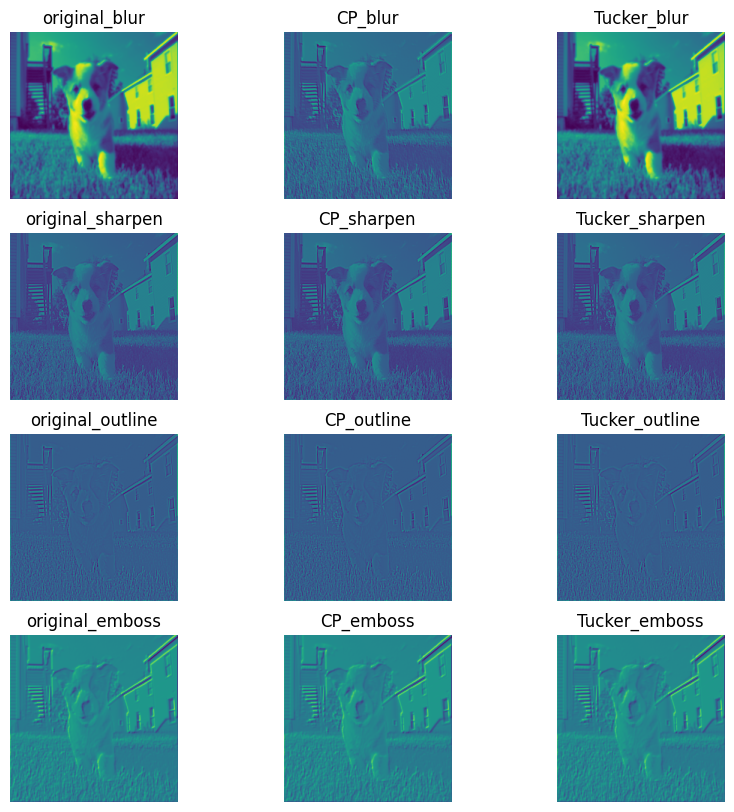

In [187]:
fig, axes = plt.subplots(4,3, figsize=(10,10))

for i in range(4):
    trs = transform_type[i]

    org = weight_to_conv(weight_tensor[i])(gray_img)
    cp = weight_to_conv(cp_reconstruction[i])(gray_img)
    tk = weight_to_conv(tk_reconstruction[i])(gray_img)

    axes[i][0].imshow(org.squeeze(0).detach().numpy())
    axes[i][0].axis("off")
    axes[i][0].set_title(f"original_{trs}")

    axes[i][1].imshow(cp.squeeze(0).detach().numpy())
    axes[i][1].axis("off")
    axes[i][1].set_title(f"CP_{trs}")
    
    axes[i][2].imshow(tk.squeeze(0).detach().numpy())
    axes[i][2].axis("off")
    axes[i][2].set_title(f"Tucker_{trs}")

이미지의 크기 (3, 64, 64) 보다 더 작은 크기인 Convolution 필터에 적용한 결과, <br>
rank를 4로 설정했음에도 CP의 blur를 제외하고는 거의 유사한 변환이 이뤄졌음을 확인할 수 있다.